# 1. Build an object detection model using pytorch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from torch.utils.data import  Subset

from torch.utils.data import random_split, Dataset
from torch.utils.data import TensorDataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

import numpy as np

from torch.utils.data import Subset
import matplotlib.pyplot as plt

import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import matplotlib.patches as patches

In [2]:
train_df = pd.read_csv('./Train.csv')
test_df = pd.read_csv('./Test.csv')
train_df.head()

imageFilename  box_position_1  box_position_2  box_position_3  \
0   GH030066_4679.png           287.0           116.0            25.0   
1  GH020058_19383.png           275.0            58.0            23.0   
2   GH030061_1269.png           306.0            74.0            26.0   
3  GH020058_17235.png             NaN             NaN             NaN   
4  GH020058_18319.png           288.0            55.0            23.0   

   box_position_4  class_names  
0            23.0           29  
1            24.0           44  
2            25.0           13  
3             NaN            0  
4            23.0           42

In [3]:
train_df, valid_df = train_test_split(train_df, test_size=0.15, random_state=42)
trans = transforms.Compose([transforms.ToTensor()])

In [4]:
class P2Dataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None,train=True):
        super().__init__()

        self.image_ids = dataframe['imageFilename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.train=train

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms is not None:  #Apply transformation
            image = self.transforms(image)
        if(self.train==False):  # For test data
            return image, image_id
        #Else for train and validation data
        records = self.df[self.df['imageFilename'] == image_id]   
        if records[['box_position_1', 'box_position_2', 'box_position_3', 'box_position_4']].isna().all(axis=1).any():
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            area = torch.zeros(0, dtype=torch.float32)
            iscrowd = torch.zeros(0, dtype=torch.int64)
        else:
            boxes = records[['box_position_1', 'box_position_2', 'box_position_3', 'box_position_4']].values
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            labels = torch.as_tensor(records['class_names'].values, dtype=torch.int64)

            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([index]),
            'area': area,
            'iscrowd': iscrowd
        }

        return image, target, image_id

In [5]:
train_dir = './Stall_num_images'
test_dir = './Stall_num_images'

In [6]:

class Averager:      
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
        
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = P2Dataset(train_df, train_dir, trans,True)
valid_dataset = P2Dataset(valid_df, train_dir, trans,True)

test_dataset = P2Dataset(test_df, test_dir, trans,True)


indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)


test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

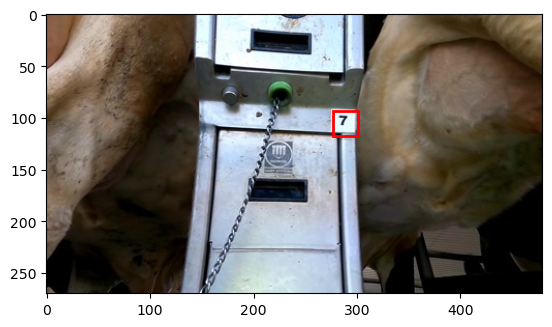

In [7]:
first_batch = next(iter(train_data_loader))
images, targets, image_ids = first_batch

first_image = images[0]
first_boxes = targets[0]['boxes']

first_image_np = first_image.permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1)

ax.imshow(first_image_np)

for box in first_boxes:
   
    x_min, y_min, x_max, y_max = box
    width, height = x_max - x_min, y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


plt.show()

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 2. Train your model using [cow stall number datasets](https://github.com/YoushanZhang/Cow_stall_number)

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 61 
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


c:\Users\liu dengyi\miniconda3\envs\pytorch-gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\liu dengyi\miniconda3\envs\pytorch-gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
def bbox_iou(box1, box2):
    """
    box1, box2 - [x_min, y_min, x_max, y_max]
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(x2 - x1, 0) * max(y2 - y1, 0)
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area_box1 + area_box2 - intersection

    return intersection / union if union > 0 else 0

In [11]:
def calculate_mean_iou(model, data_loader, device):
    total_iou = 0.0
    total_boxes = 0

    model.eval()
    with torch.no_grad():
        for images, targets, _ in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].data.cpu()
                true_boxes = targets[i]['boxes'].data.cpu()

                for pred_box in pred_boxes:
                    ious = [bbox_iou(pred_box, true_box) for true_box in true_boxes]
                    max_iou = max(ious, default=0)  
                    total_iou += max_iou
                    total_boxes += 1

    mean_iou = total_iou / total_boxes if total_boxes > 0 else 0
    return mean_iou


In [12]:
def calculate_label_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0

    model.eval()
    with torch.no_grad():
        for images, targets, image_ids in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_labels = output['labels'].data.cpu()
                true_labels = targets[i]['labels'].data.cpu()

                
                if len(true_labels) == 0:
  
                    correct_predictions += 1 if len(pred_labels) == 0 else 0
                else:

                    if len(pred_labels) > 0 and pred_labels[0] == true_labels[0]:
                        correct_predictions += 1

                total_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

In [13]:
def evaluate(model, data_loader, device):
    model.train()  
    total_loss = 0.0

    with torch.no_grad():  
        for images, targets, _ in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    model.eval()
    return total_loss / len(data_loader)

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 50 #100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_ious = []
val_ious = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets, image_ids in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
   
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
        
    train_loss = running_loss / len(train_data_loader)
    train_losses.append(train_loss)
    
    val_loss = evaluate(model, valid_data_loader, device)
    val_losses.append(val_loss)
    
    train_iou = calculate_mean_iou(model, train_data_loader, device)
    val_iou = calculate_mean_iou(model, valid_data_loader, device)
    train_accuracy = calculate_label_accuracy(model, train_data_loader, device)
    val_accuracy = calculate_label_accuracy(model, valid_data_loader, device)

    train_ious.append(train_iou)
    val_ious.append(val_iou)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/50, Train Loss: 0.4810, Val Loss: 0.3781
Train IoU: 0.8040, Val IoU: 0.8018
Train Accuracy: 0.1898, Val Accuracy: 0.1783
Epoch 2/50, Train Loss: 0.3686, Val Loss: 0.3213
Train IoU: 0.8350, Val IoU: 0.8292
Train Accuracy: 0.1921, Val Accuracy: 0.1975
Epoch 3/50, Train Loss: 0.2984, Val Loss: 0.2778
Train IoU: 0.8281, Val IoU: 0.8285
Train Accuracy: 0.2147, Val Accuracy: 0.2548
Epoch 4/50, Train Loss: 0.2633, Val Loss: 0.2312
Train IoU: 0.8263, Val IoU: 0.8234
Train Accuracy: 0.2723, Val Accuracy: 0.2994
Epoch 5/50, Train Loss: 0.2224, Val Loss: 0.2023
Train IoU: 0.8258, Val IoU: 0.8199
Train Accuracy: 0.2881, Val Accuracy: 0.3057
Epoch 6/50, Train Loss: 0.1895, Val Loss: 0.1787
Train IoU: 0.8212, Val IoU: 0.8154
Train Accuracy: 0.3785, Val Accuracy: 0.3121
Epoch 7/50, Train Loss: 0.1606, Val Loss: 0.1432
Train IoU: 0.7980, Val IoU: 0.7913
Train Accuracy: 0.6350, Val Accuracy: 0.6306
Epoch 8/50, Train Loss: 0.1259, Val Loss: 0.1093
Train IoU: 0.8051, Val IoU: 0.7939
Train Accurac

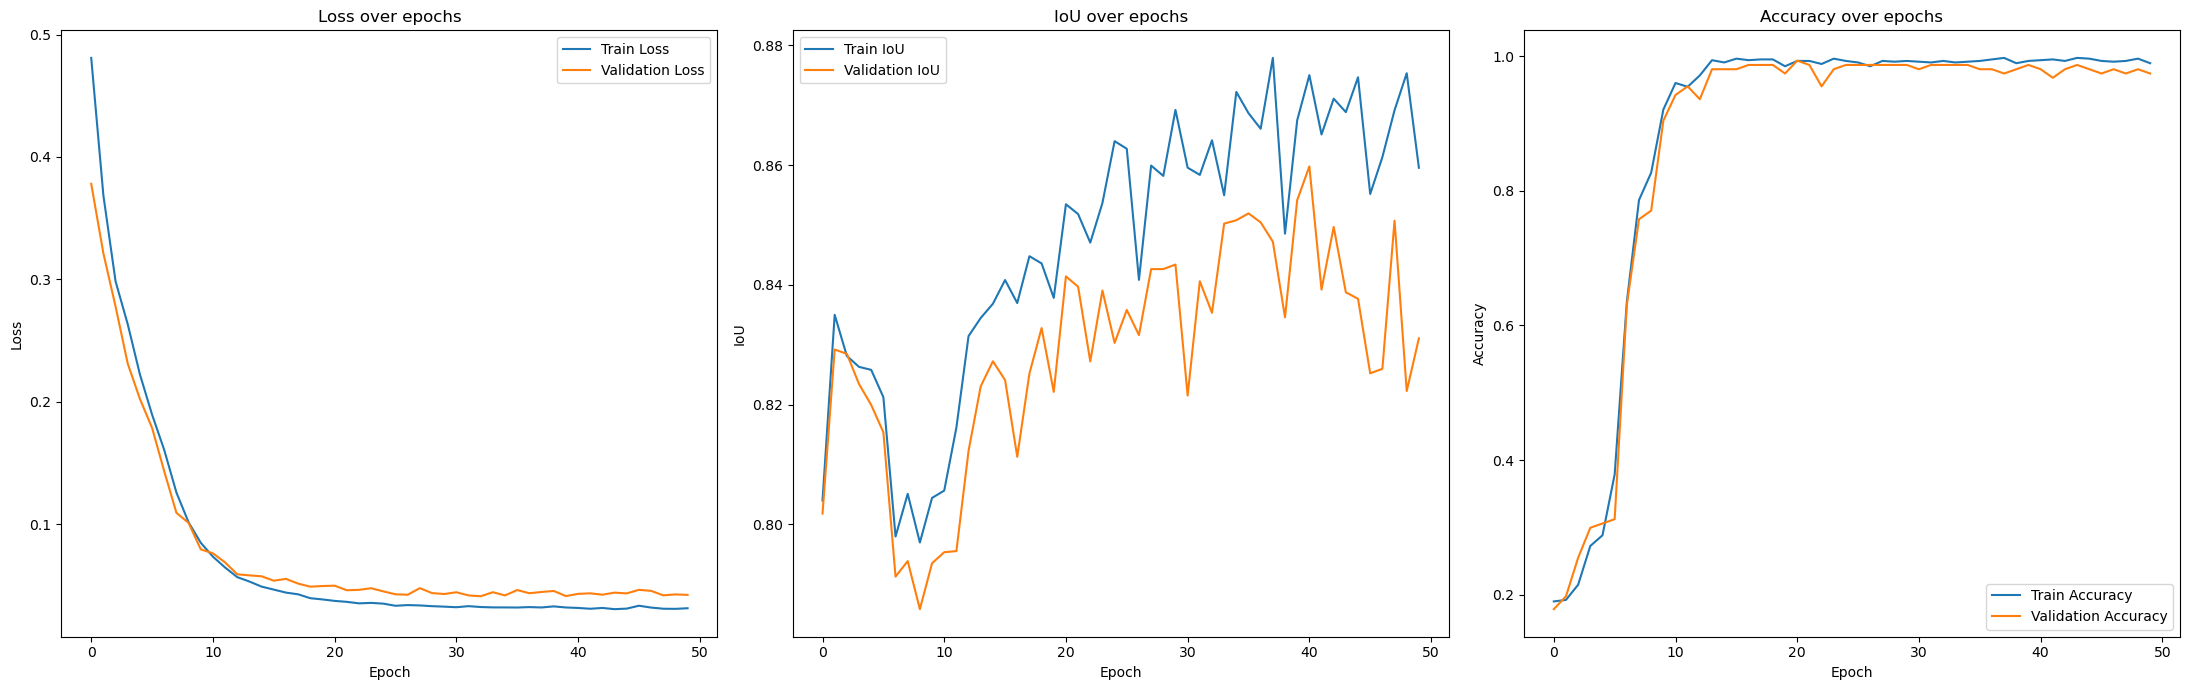

In [24]:
plt.figure(figsize=(22, 7))  

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Validation IoU')
plt.title('IoU over epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



plt.tight_layout()  
plt.show()


# 3.Evaluate your model using the test images

In [17]:
test_iou = calculate_mean_iou(model, test_data_loader, device) 
test_accuracy = calculate_label_accuracy(model, test_data_loader, device) 


print(f" Test IoU: {test_iou:.2f}")
print(f"Test Label Accuracy: {test_accuracy:.2f}")


 Test IoU: 0.82
Test Label Accuracy: 0.98


# 4. Your results should be higher than 80%.

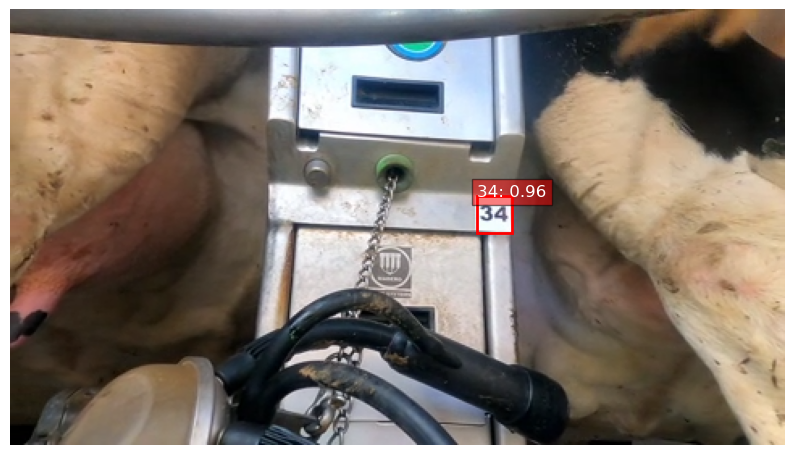

In [25]:
model.eval()

image_path = './Stall_num_images/GH020066_6340.png'
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

transformed_image = trans(original_image)
transformed_image = transformed_image.unsqueeze(0) 

transformed_image = transformed_image.to(device)

with torch.no_grad():
    prediction = model(transformed_image)

plt.figure(figsize=(10, 10))
plt.imshow(original_image)

for element in range(len(prediction[0]['boxes'])):
    boxes = prediction[0]['boxes'][element].cpu().numpy()
    score = prediction[0]['scores'][element].cpu().numpy()
    label = prediction[0]['labels'][element].cpu().numpy()

    if score > 0.5:  
        x1, y1, x2, y2 = boxes
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x1, y1, f"{label}: {score:.2f}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.show()

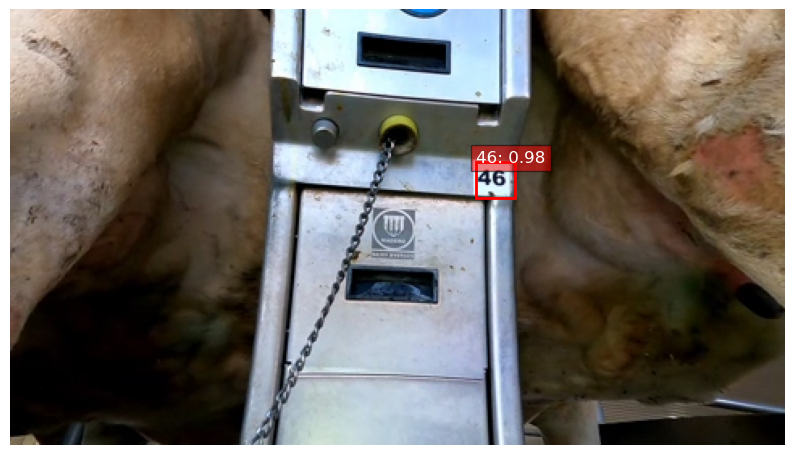

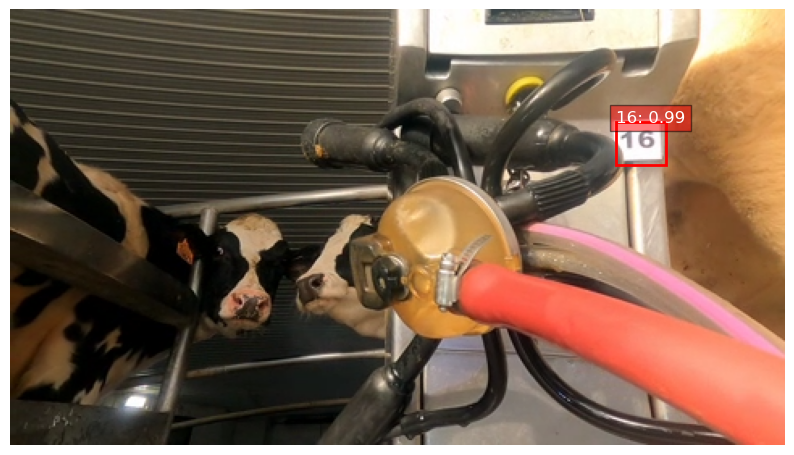

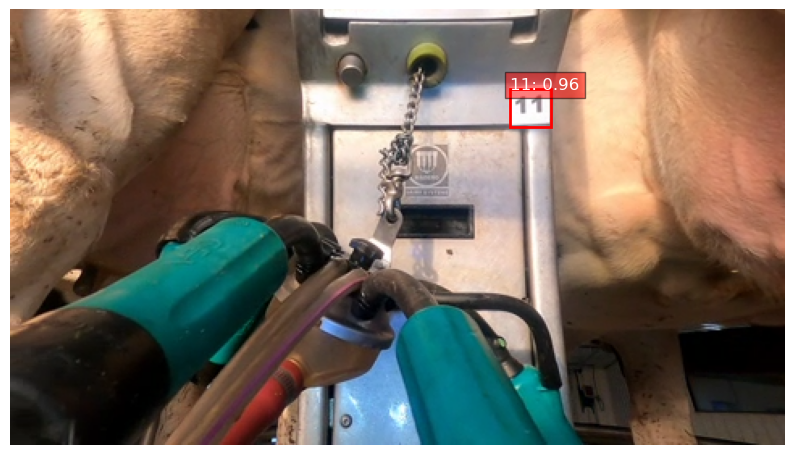

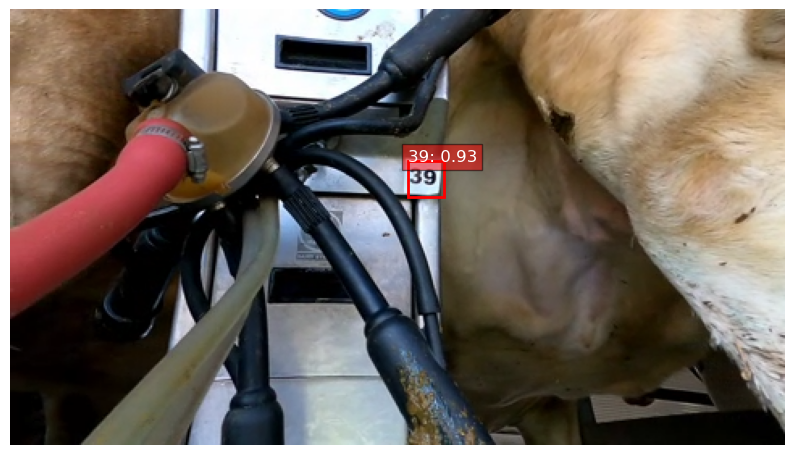

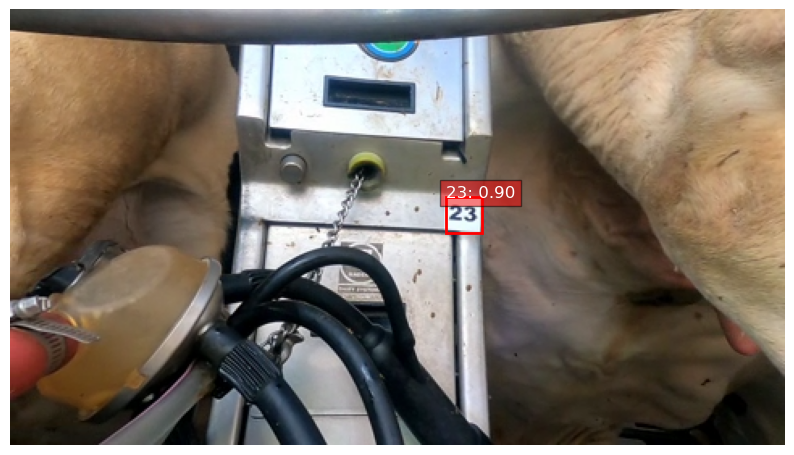

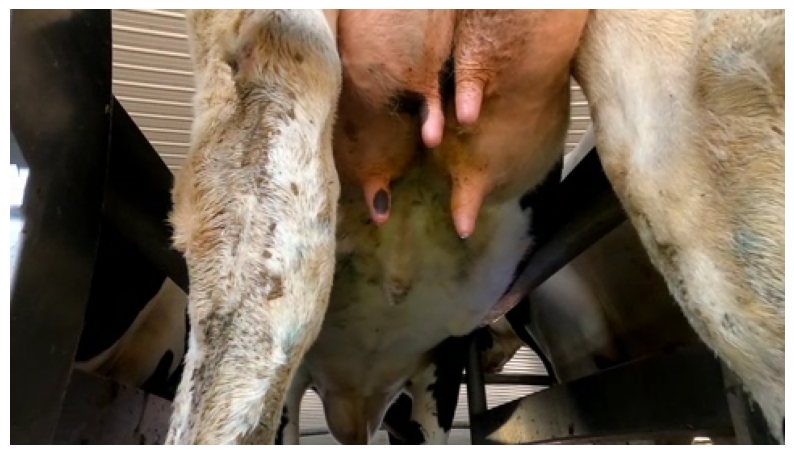

In [34]:
model.eval()

def display_prediction(image_path, model, device, transform, threshold=0.5):
    # Read and transform the image
    original_image = Image.open(image_path).convert("RGB")
    transformed_image = transform(original_image)
    transformed_image = transformed_image.unsqueeze(0) 
    transformed_image = transformed_image.to(device)

    # Get predictions
    with torch.no_grad():
        prediction = model(transformed_image)

    # Convert to numpy and display
    plt.figure(figsize=(10, 10))
    plt.imshow(np.array(original_image))
    
    for element in range(len(prediction[0]['boxes'])):
        boxes = prediction[0]['boxes'][element].cpu().numpy()
        score = prediction[0]['scores'][element].cpu().numpy()
        label = prediction[0]['labels'][element].cpu().numpy()

        if score > threshold:  
            x1, y1, x2, y2 = boxes
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x1, y1, f"{label}: {score:.2f}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# List of image paths
image_paths = [
    './Stall_num_images/GH030072_4929.png',
    './Stall_num_images/GH010060_31769.png',
    './Stall_num_images/GH020058_1417.png',
    './Stall_num_images/GH010071_20337.png',  # Make sure the extension '.png' is correct
    './Stall_num_images/GH020066_211.png',
    './Stall_num_images/GH020071_7681.png'
]

# Display predictions for each image
for path in image_paths:
    display_prediction(path, model, device, trans)


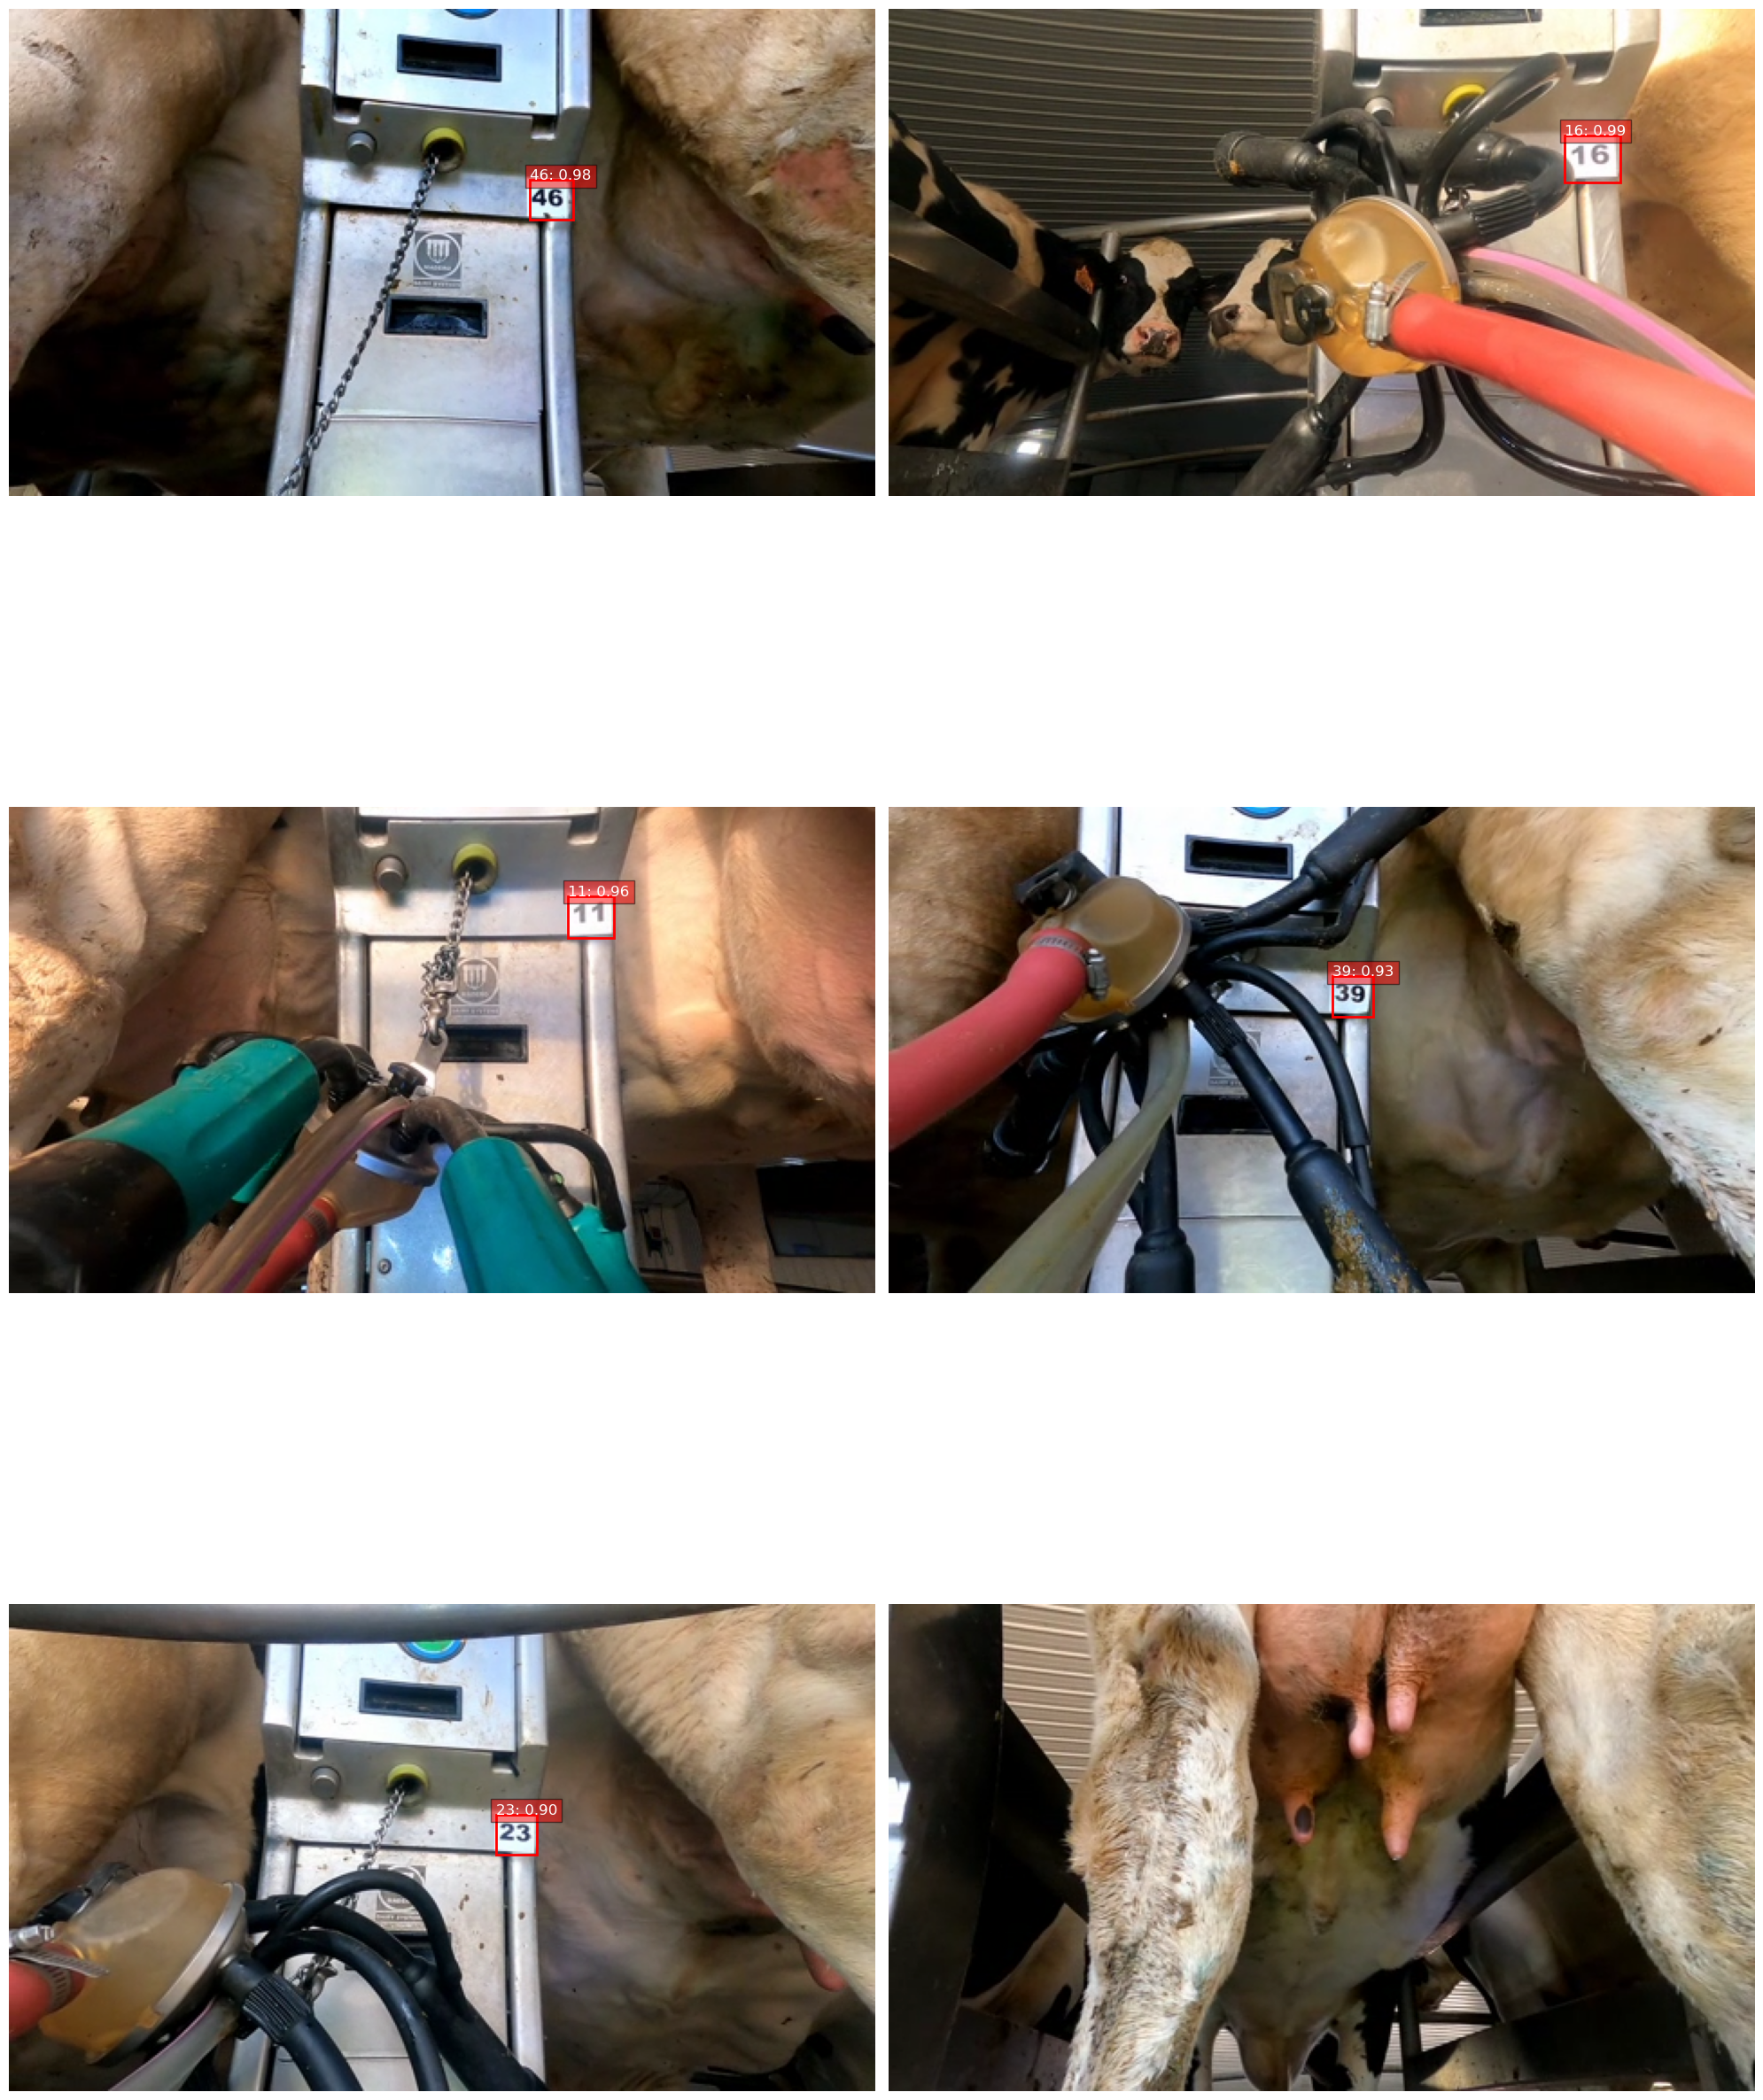

In [35]:
import math

def display_predictions(image_paths, model, device, transform, threshold=0.5):
    # Calculate the number of rows and columns for the subplot grid
    num_images = len(image_paths)
    num_cols = 2
    num_rows = math.ceil(num_images / num_cols)

    # Set the figure size based on the number of images
    plt.figure(figsize=(num_cols * 10, num_rows * 10))
    
    # Iterate over image paths and display each one
    for idx, image_path in enumerate(image_paths):
        original_image = Image.open(image_path).convert("RGB")
        transformed_image = transform(original_image)
        transformed_image = transformed_image.unsqueeze(0)
        transformed_image = transformed_image.to(device)

        with torch.no_grad():
            prediction = model(transformed_image)
        
        # Create a subplot for each image
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.imshow(np.array(original_image))

        for element in range(len(prediction[0]['boxes'])):
            boxes = prediction[0]['boxes'][element].cpu().numpy()
            score = prediction[0]['scores'][element].cpu().numpy()
            label = prediction[0]['labels'][element].cpu().numpy()

            if score > threshold:
                x1, y1, x2, y2 = boxes
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1, f"{label}: {score:.2f}", color='white', fontsize=12, 
                        bbox=dict(facecolor='red', alpha=0.5))

        # Turn off the axis
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# List of image paths
image_paths = [
    './Stall_num_images/GH030072_4929.png',
    './Stall_num_images/GH010060_31769.png',
    './Stall_num_images/GH020058_1417.png',
    './Stall_num_images/GH010071_20337.png',  # Make sure the extension '.png' is correct
    './Stall_num_images/GH020066_211.png',
    './Stall_num_images/GH020071_7681.png'
]

# Display predictions for each image
display_predictions(image_paths, model, device, trans)



# 5. Write a four-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points